### #import thư viện cần thiết

In [31]:
import re# thư viện để python làm việc với biểu thức chính quy
import csv# thư viện để xử lí file .csv
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer# thư viện để tokenize
from pyvi import ViUtils 

### # ghi dữ liệu sang một file mới
### # loại bỏ stopword, kí tự, viết hoa
### # kiểm tra xem có comment hoặc label nào bị trống không

In [32]:
# đọc dữ liệu từ file gốc và sau đó loại bỏ stopwords và lưu lại vào file ra
input_file_path = 'review_update.csv'  # File CSV cần xử lý
output_file_path = 'data.csv'       # File CSV đầu ra
# Hàm đọc danh sách stopwords từ file
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())  # Đọc từng dòng và lưu vào set
    return stopwords
# Lấy danh sách stopwords từ file
stopwords = load_stopwords('vietnamese_stopwords.txt')
# Hàm làm sạch văn bản
def clean_text(text):
    # Chuyển tất cả chữ về dạng viết thường
    text = text.lower()
    # Loại bỏ emoji, ký tự đặc biệt, chỉ giữ lại chữ cái và khoảng trắng
    text = re.sub(r'[^\w\sáàạảãạăắằặẳẵâấầậẩẫéèẹẻẽêếềệểễíìịỉĩóòọỏõôốồộổỗơớờợởỡúùụủũưứừựửữýỳýỵỷỹđ]', '', text)
    # Loại bỏ stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text
# Đọc dữ liệu từ file CSV
try:
    with open(input_file_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        data1 = list(reader)  # Đọc toàn bộ dữ liệu từ file CSV
except FileNotFoundError:
    print(f"Không tìm thấy file: {input_file_path}")
    exit()
except csv.Error:
    print(f"Lỗi khi đọc file CSV: {input_file_path}")
    exit()
# Lọc và xử lý các mục comment, kiểm tra label và chỉ ghi lại những phần hợp lệ
processed_data1 = []
empty_rows = []  # Danh sách lưu dòng có dữ liệu trống
for index, item in enumerate(data1):
    comment = item.get('Comment', '').strip()
    label = item.get('Label', '').strip()
    # Kiểm tra dòng nào có dữ liệu bị trống
    if not comment or not label:
        empty_rows.append(index + 1)  # Lưu chỉ mục dòng (bắt đầu từ 1)
        continue
    # Xử lý comment
    cleaned_comment = clean_text(comment)
    processed_data1.append({'Comment': cleaned_comment, 'Label': label})
# Báo các dòng có dữ liệu bị trống
if empty_rows:
    print(f"Các dòng sau có dữ liệu trống ở cột 'Comment' hoặc 'Label': {empty_rows}")
# Ghi lại dữ liệu đã xử lý vào file CSV mới
try:
    with open(output_file_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['Comment', 'Label'])
        writer.writeheader()  # Ghi tiêu đề cột
        writer.writerows(processed_data1)  # Ghi dữ liệu
    print(f"Dữ liệu đã được ghi vào {output_file_path}")
except IOError:
    print(f"Không thể ghi dữ liệu vào file {output_file_path}")

Các dòng sau có dữ liệu trống ở cột 'Comment' hoặc 'Label': [2401, 2868]
Dữ liệu đã được ghi vào data.csv


In [33]:
# phân loại từ cơ bản để xem có bao nhiêu từ hơn 500 từ
def classify_comments_by_length(csv_file_path):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(csv_file_path)  
    # Kiểm tra xem cột 'comment' có tồn tại trong dữ liệu không
    if 'Comment' not in df.columns:
        raise ValueError("File CSV không chứa cột 'comment'")  
    # Hàm để đếm số lượng từ trong một comment
    def count_words(text):
        if isinstance(text, str):  # Kiểm tra xem text có phải là chuỗi không
            return len(text.split())
        return 0  
    # Phân loại thành hai nhóm: nhóm có trên 500 từ và nhóm có dưới 500 từ
    group_above_500 = df[df['Comment'].apply(count_words) > 500]
    group_below_500 = df[df['Comment'].apply(count_words) <= 500]  
    # In ra số lượng dòng trong mỗi nhóm
    print(f"Số lượng comment có hơn 500 từ: {len(group_above_500)}")
    print(f"Số lượng comment có 500 từ trở xuống: {len(group_below_500)}")   
    return group_above_500, group_below_500
# Đường dẫn tới file CSV của bạn
csv_file_path = 'data.csv'
# Gọi hàm để phân loại các comment
group_above_500, group_below_500 = classify_comments_by_length(csv_file_path)
# In ra ví dụ cho mỗi nhóm
print("\nMột số ví dụ trong nhóm có hơn 500 từ:")
print(group_above_500.head())
print("\nMột số ví dụ trong nhóm có dưới 500 từ:")
print(group_below_500.head())


Số lượng comment có hơn 500 từ: 7
Số lượng comment có 500 từ trở xuống: 3226

Một số ví dụ trong nhóm có hơn 500 từ:
                                                Comment     Label
232   điên có đôi lời tựa của phần này có lẽ không h...  positive
239   với mình nếu tách những cảnh tưởng tượng ra kh...  positive
1336  giờ chưa từng phân tích phim hay bình luận suy...  negative
1380  về điểm khen mình không kiến còn về phần chê b...  negative
1386  có lẽ là câu chuyện quan điểm cá nhân mình ko ...  positive

Một số ví dụ trong nhóm có dưới 500 từ:
                                             Comment     Label
0  p1 kiệt tác mọi thời đại rồi nên cũng đừng kì ...   neutral
1  p2 gần là 1 phần bôi nhọ p1 ai lại có thể nghĩ...  negative
2  năm nay kiểu gì toàn bom tấn thành bom xịt phi...  negative
3  đúng là cảm xúc các đoạn cao trào vẫn làm chưa...   neutral
4           phim khúc cuối nó dở 1 cái phim việt nam  negative


In [34]:
data = pd.read_csv('data.csv')
data.head()

,Comment,Label
0,p1 kiệt tác mọi thời đại rồi nên cũng đừng kì ...,neutral
1,p2 gần là 1 phần bôi nhọ p1 ai lại có thể nghĩ...,negative
2,năm nay kiểu gì toàn bom tấn thành bom xịt phi...,negative
3,đúng là cảm xúc các đoạn cao trào vẫn làm chưa...,neutral
4,phim khúc cuối nó dở 1 cái phim việt nam,negative


### #Lọc comment và label

In [35]:
st_data =pd.DataFrame({'Comment': data['Comment'],'Label': data['Label']})
st_data = st_data.dropna()
st_data = st_data.reset_index(drop=True)
st_data.head()

,Comment,Label
0,p1 kiệt tác mọi thời đại rồi nên cũng đừng kì ...,neutral
1,p2 gần là 1 phần bôi nhọ p1 ai lại có thể nghĩ...,negative
2,năm nay kiểu gì toàn bom tấn thành bom xịt phi...,negative
3,đúng là cảm xúc các đoạn cao trào vẫn làm chưa...,neutral
4,phim khúc cuối nó dở 1 cái phim việt nam,negative


In [36]:
#đếm số lượng các nhãn
import pandas as pd
def count_labels_in_csv(file_path, label_column):
    try:
        # Đọc file CSV
        data = pd.read_csv(file_path)
        # Kiểm tra cột label có tồn tại không
        if label_column not in data.columns:
            print(f"Cột '{label_column}' không tồn tại trong file CSV.")
            return
        # Đếm số lượng xuất hiện của mỗi nhãn
        label_counts = data[label_column].value_counts()
        # In kết quả
        print("Số lượng các nhãn trong cột '{}' là:".format(label_column))
        for label, count in label_counts.items():
            print(f"{label}: {count}")
    except FileNotFoundError:
        print("File không tồn tại. Vui lòng kiểm tra đường dẫn.")
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")
# Ví dụ sử dụng
file_path = "data.csv"  # Thay đường dẫn đến file CSV của bạn
label_column = "Label"  # Thay tên cột Label của bạn
count_labels_in_csv(file_path, label_column)


Số lượng các nhãn trong cột 'Label' là:
negative: 1144
positive: 1129
neutral: 960


### # Tạo một bản sao không có dấu, tokenization & lưu tạm

In [37]:
input_comment = st_data['Comment'].values
input_label = st_data['Label'].values
label_dictionary ={'positive':2,'neutral':1,'negative':0}
input_pre =[]
label_accent =[]
for idx, dt in enumerate(input_comment):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))# phần này là phần đã loại bỏ dấu
    input_text_pre_accent =ViTokenizer.tokenize(input_text_pre)# tokenization cho văn bản có dấu
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)# tokenization cho văn bản đã loại bỏ dấu
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_accent.append(input_label[idx])
    label_accent.append(input_label[idx])

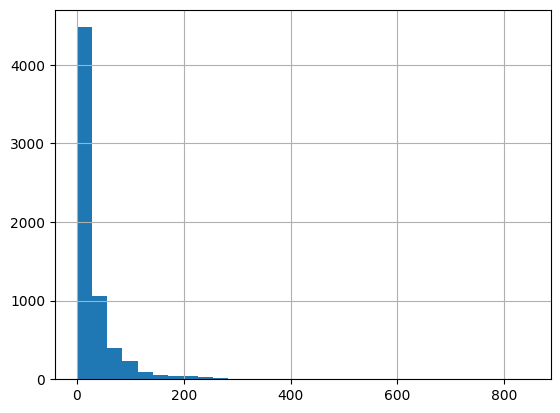

In [38]:
# lấy thông số và kiểm tra tần xuất
seq_len =[len(i.split())for i in input_pre[0:7000]]
pd.Series(seq_len).hist(bins =30)
plt.show()


In [39]:
# chuyển đổi nhãn thành số và dạng one hot encoding
label_idx =[label_dictionary[i]for i in label_accent]
label_tf =tf.keras.utils.to_categorical(label_idx,num_classes=3)
# Tạo một tokenizer cho việc tách từ trong văn bản
tokenizer_data=Tokenizer(oov_token='<OOV>', split=' ')
# huấn luyện
tokenizer_data.fit_on_texts(input_pre)
# chuyển văn bản thành các chuỗi số
tokenizer_data_text=tokenizer_data.texts_to_sequences(input_pre)
# Padding các chuỗi số, đảm bảo mỗi chuỗi có độ dài cố định (512 từ)
vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen=512)
# Lưu tokenizer đã huấn luyện vào file pickle để sử dụng sau này
pickle.dump(tokenizer_data,open("tokenizer_data.pkl", "wb"))
print("comment data.shape ",vec_data.shape)
data_voca_size =len(tokenizer_data.word_index)+1
print("data_voca_size: ",data_voca_size)
#chia tệp dữ liệu thành bộ train và bộ validation 8-2
x_train, x_val,y_train,y_val= train_test_split(vec_data, label_tf,test_size=0.2,random_state=42)
#chia tệp dữ liệu thành bộ train và bộ test 9-1
x_train, x_test,y_train,y_test= train_test_split(vec_data, label_tf,test_size=0.1,random_state=42)
print("training sample: ",len(x_train))
print("validation sample: ",len(x_val))
print("test sample: ",len(x_test))

comment data.shape  (6460, 512)
data_voca_size:  6699
training sample:  5814
validation sample:  1292
test sample:  646


### # Build CNN +Bidirectional KSTM model for vietnamese language

In [40]:
def generate_model():# hàm chạy chính cho model kstm và cnn
    dropout_threshold =0.3
    input_dim =data_voca_size
    ouput_dim =32
    input_length = 512
    initializer= tf.keras.initializers.GlorotNormal()
    input_layer = Input(shape=(input_length,))
    feature =Embedding(input_dim=input_dim, output_dim=ouput_dim, embeddings_initializer="GlorotNormal")(input_layer)
    cnn_feature =Conv1D(filters=32, kernel_size=3, padding='same',activation='relu')(feature)
    cnn_feature =MaxPooling1D()(cnn_feature)
    cnn_feature =Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same',activation='relu')(cnn_feature)
    cnn_feature =MaxPooling1D()(cnn_feature)
    cnn_feature =LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    #bidirectional kstm
    bi_sktm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
    bi_sktm_feature = MaxPooling1D()(bi_sktm_feature)
    bi_sktm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(bi_sktm_feature)
    bi_sktm_feature = MaxPooling1D()(bi_sktm_feature)
    bi_sktm_feature = LayerNormalization()(bi_sktm_feature)
    
    combine_feature =tf.keras.layers.Concatenate()([cnn_feature,bi_sktm_feature])
    combine_feature =GlobalMaxPooling1D()(combine_feature)
    combine_feature =LayerNormalization()(combine_feature)
    
    Classifier =Dense(90, activation='relu')(combine_feature)
    Classifier =Dropout(0.2)(Classifier)

    Classifier = Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Classifier)
    Classifier =Dropout(0.2)(Classifier)
    Classifier =Dense(3, activation='softmax')(Classifier)
    model= tf.keras.Model(inputs = input_layer, outputs =Classifier)
    return model
model =generate_model()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0009,
    decay_steps=500,
    decay_rate=0.6
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer = Adam(learning_rate=lr_schedule),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 512, 32)   │    214,368 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 512, 32)   │      3,104 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 256, 32)   │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256, 32)   │          0 │ max_pooling1d_16… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 512, 64)   │     16,640 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 256, 32)   │      3,104 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 256, 64)   │          0 │ bidirectional_8[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 128, 32)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 256, 64)   │     18,816 │ max_pooling1d_18… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 32)   │         64 │ max_pooling1d_17… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 128, 64)   │          0 │ bidirectional_9[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128, 32)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ max_pooling1d_19… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 96)   │          0 │ dropout_17[0][0], │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ concatenate_4[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96)        │        192 │ global_max_pooli… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 267,969 (1.02 MB)

 Trainable params: 267,969 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### # Define model checkPoint & training

In [41]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi giá trị val_loss
    patience=5,          # Số epoch không cải thiện trước khi dừng
    restore_best_weights=True,  # Khôi phục trọng số tốt nhất
    verbose=1
)
callback_model =tf.keras.callbacks.ModelCheckpoint('model_1.keras',monitor='val_loss')
history =model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val),epochs=20, batch_size=64,callbacks=[callback_model,early_stopping])

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - accuracy: 0.3489 - loss: 1.5528 - val_accuracy: 0.3715 - val_loss: 1.3479
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 351ms/step - accuracy: 0.3734 - loss: 1.3139 - val_accuracy: 0.3398 - val_loss: 1.2354
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 361ms/step - accuracy: 0.3800 - loss: 1.2151 - val_accuracy: 0.4760 - val_loss: 1.1534
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - accuracy: 0.4398 - loss: 1.1322 - val_accuracy: 0.5944 - val_loss: 0.9623
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 395ms/step - accuracy: 0.6012 - loss: 0.9396 - val_accuracy: 0.6625 - val_loss: 0.8511
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 437ms/step - accuracy: 0.6957 - loss: 0.7803 - val_accuracy: 0.7345 - val_loss: 0.7229
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 462ms/step - accuracy: 0.7772 - loss: 0.6150 - val_accuracy: 0.7585 - val_loss: 0.6497
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 467ms/step - accuracy: 0.8323 - loss: 0.5120 - val_accu

### #model load on test data

In [46]:
model.load_weights("model_1.keras")
model.evaluate(x_test,y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6138 - loss: 1.5342


[1.4552323818206787, 0.6439628601074219]

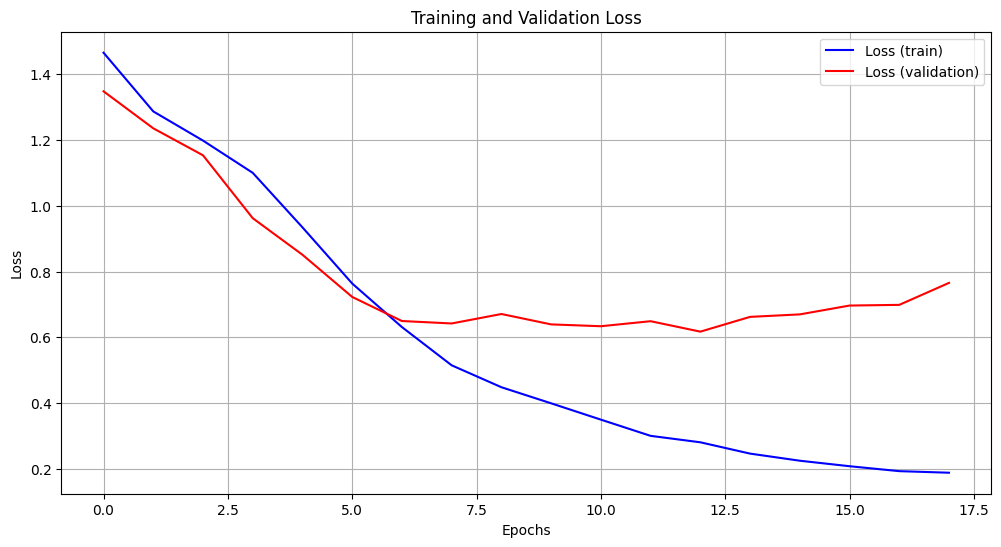

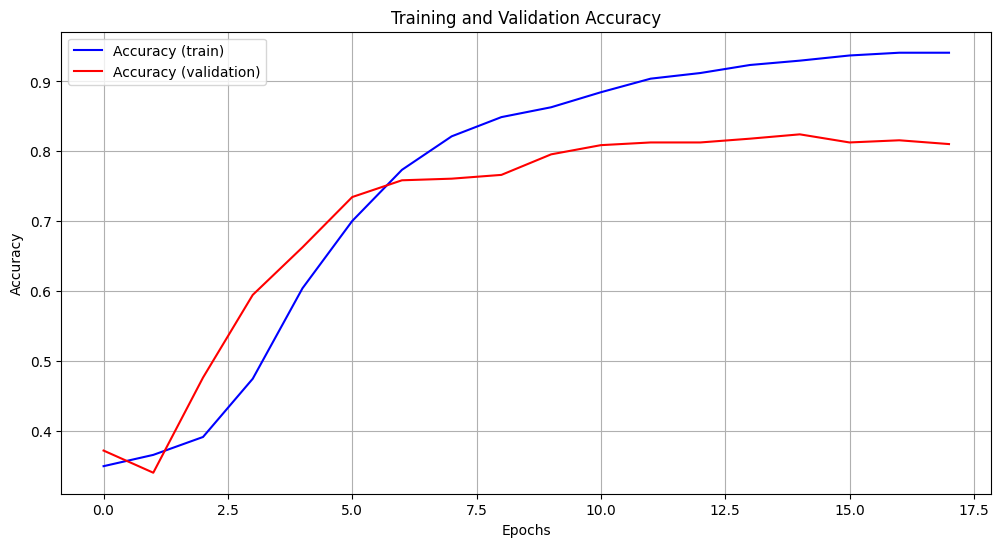

In [43]:
import matplotlib.pyplot as plt

# Vẽ đồ thị loss
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Loss (train)', color='blue')
    plt.plot(history.history['val_loss'], label='Loss (validation)', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ đồ thị accuracy
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Accuracy (train)', color='blue')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation)', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sau khi huấn luyện mô hình, vẽ các đồ thị
plot_loss(history)
plot_accuracy(history)

In [44]:
def preprocess_input(raw_input, tokenizer):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre =" ".join(input_text_pre)
    input_text_pre_accent= ViTokenizer.tokenize(input_text_pre)
    print("text preprocessed: ",input_text_pre_accent)
    tokenizer_data_text=tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen =512)
    return vec_data
def inference_model(input_feature,model):
    output=model(input_feature).numpy()[0]
    result =output.argmax()
    conf =float(output.max())
    label_dictionary={'negative':0,'neutral':1,'positive':2}
    label =list(label_dictionary.keys())
    return label[int(result)],conf
def prediction(raw_input, tokenizer,model):
    input_model=preprocess_input(raw_input,tokenizer_data)
    result,conf=inference_model(input_model,model)
    return result, conf
m_model= generate_model()
m_model=load_model('model_1.keras')
with open(r"tokenizer_data.pkl","rb")as input_file:
    my_tokenizer=pickle.load(input_file)
print(prediction("Bộ phim cảm giác như một nỗ lực thiếu sáng tạo với cốt truyện khá nhàm chán và thiếu sự sâu sắc. Các tình tiết không có gì mới mẻ và dễ dàng đoán trước, khiến người xem khó có thể cảm thấy bất ngờ hay hứng thú. Diễn xuất của dàn nhân vật không đủ thuyết phục, và họ dường như chỉ làm tròn vai mà không mang lại cảm xúc mạnh mẽ. Hình ảnh và âm thanh, mặc dù không tệ, nhưng lại không đủ để nâng cao trải nghiệm cho bộ phim, khiến nó trở nên bình thường và dễ quên. Bộ phim không đạt được mục tiêu của mình là thu hút và giữ chân khán giả, và có cảm giác như một sản phẩm thiếu đầu tư và sự tâm huyết",my_tokenizer,m_model))

text preprocessed:  bộ phim cảm_giác như một nỗ_lực thiếu sáng_tạo với cốt_truyện khá nhàm_chán và thiếu sự sâu_sắc các tình_tiết không có gì mới_mẻ và dễ_dàng đoán trước khiến người xem khó có_thể cảm_thấy bất_ngờ hay hứng_thú diễn_xuất của dàn nhân_vật không đủ thuyết_phục và họ dường_như chỉ làm_tròn vai mà không mang lại cảm_xúc mạnh_mẽ hình_ảnh và âm_thanh mặc_dù không tệ nhưng lại không đủ để nâng cao trải nghiệm cho bộ phim khiến nó trở_nên bình_thường và dễ quên bộ phim không đạt được mục_tiêu của mình là thu_hút và giữ_chân khán_giả và có cảm_giác như một sản_phẩm thiếu đầu_tư và sự tâm_huyết
('negative', 0.5238725543022156)


In [45]:
#while(True):
 #   text=input()
   # if text =="end":
   #     break
   # else:
    #    print(prediction(text,my_tokenizer,m_model)[0]+"\n")